In [37]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from IPython.display import Image
from IPython.core.display import HTML
import scipy.integrate
import math
import pandas as pd
from numpy.linalg import matrix_power
from scipy.linalg import expm
import os
import time
from itertools import count, takewhile
from more_itertools import numeric_range
from playsound import playsound
from tqdm import tqdm

%matplotlib inline

In [38]:
filenames = os.listdir("./data/sim-runs/")

state_sequences = []
control_sequences = []
r_left_sequences = []
r_right_sequences = []

for name in filenames:
    try:
        state_sequences.append(pd.read_csv("./data/sim-runs/" + name).iloc[:, range(2, 2+12)].values)
        control_sequences.append(pd.read_csv("./data/sim-runs/" + name).iloc[:, range(26, 26+6)].values)
        r_left_sequences.append(pd.read_csv("./data/sim-runs/" + name).iloc[:, range(32, 32+3)].values)
        r_right_sequences.append(pd.read_csv("./data/sim-runs/" + name).iloc[:, range(35, 35+3)].values)
    except:
        print("Invalid parse with filename:", name)

state_sequences[0][2,5]

1.11267

In [39]:
I_body = np.array([[0.45, 0., 0.],
                        [0., 0.64, 0.],
                        [0., 0., 0.584]]) # Inertia in the body frame (CoM of torso).
    
torso_mass = 30
dt = 1/50
n = 13
num_observed_states = 9

low_sigma = 0.01
high_sigma = 0.1
num_samples = 10000

# Q diagonal terms are sigma^2
Q = np.diag([0.0802302108692834**2, 0.01305666461938923**2, 0.01107077119525087**2, 0.0009011313906460847**2, 0.00023698396170725926**2, 0.00044577065046749395**2, 8.017754980742252**2, 1.2604137854858983**2, 0.9853310110200274**2, 0.012333371098149101**2, 0.015200679893270697**2, 0.028277163175850512**2])

R = np.diag([low_sigma**2, low_sigma**2, low_sigma**2, low_sigma**2, low_sigma**2, low_sigma**2, high_sigma**2, high_sigma**2, high_sigma**2])

Ixx = I_body[0, 0]
Ixy = I_body[0, 1]
Ixz = I_body[0, 2]

Iyx = I_body[1, 0]
Iyy = I_body[1, 1]
Iyz = I_body[1, 2]

Izx = I_body[2, 0]
Izy = I_body[2, 1]
Izz = I_body[2, 2]

In [40]:
noise_vector = []

for i in range(9):
    if i < 6:
        noise_vector.append(np.random.normal(0, low_sigma, num_samples))
    else:
        noise_vector.append(np.random.normal(0, high_sigma, num_samples))

noise_vector_fixed = [0] * num_samples

for i in range(num_samples):
    noise_vector_fixed[i] = [noise_vector[temp][i] for temp in range(num_observed_states)]

noise_vector = noise_vector_fixed

In [41]:
def discretize_ss(x_t, u_t, r_x_left, r_x_right, r_y_left, r_y_right, r_z_left, r_z_right, dt):
    phi = x_t[0]
    theta = x_t[1]
    psi = x_t[2]

    I_world = np.array([[(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi))*(Ixz*math.cos(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izz*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi))) + (math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi))*(Ixy*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)) + Ixy*math.cos(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi))) + (Ixx*math.cos(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izx*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)))*math.cos(psi)*math.cos(theta), (-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi))*(Ixz*math.cos(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izz*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi))) + (math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi))*(Ixy*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)) + Ixy*math.cos(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi))) + (Ixx*math.cos(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izx*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)))*math.sin(psi)*math.cos(theta), (Ixy*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)) + Ixy*math.cos(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)))*math.sin(phi)*math.cos(theta) - (Ixx*math.cos(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izx*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)))*math.sin(theta) + (Ixz*math.cos(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi)) + Izz*(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi)))*math.cos(phi)*math.cos(theta)], [(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi))*(Ixz*math.sin(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izz*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi))) + (math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi))*(Ixy*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)) + Ixy*math.sin(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi))) + (Ixx*math.sin(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izx*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)))*math.cos(psi)*math.cos(theta), (-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi))*(Ixz*math.sin(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izz*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi))) + (math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi))*(Ixy*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)) + Ixy*math.sin(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi))) + (Ixx*math.sin(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izx*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)))*math.sin(psi)*math.cos(theta), (Ixy*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)) + Ixy*math.sin(psi)*math.cos(theta) + Iyy*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)))*math.sin(phi)*math.cos(theta) - (Ixx*math.sin(psi)*math.cos(theta) + Iyx*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izx*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)))*math.sin(theta) + (Ixz*math.sin(psi)*math.cos(theta) + Iyz*(math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi)) + Izz*(-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi)))*math.cos(phi)*math.cos(theta)], [(math.sin(phi)*math.sin(psi) + math.sin(theta)*math.cos(phi)*math.cos(psi))*(-Ixz*math.sin(theta) + Iyz*math.sin(phi)*math.cos(theta) + Izz*math.cos(phi)*math.cos(theta)) + (math.sin(phi)*math.sin(theta)*math.cos(psi) - math.sin(psi)*math.cos(phi))*(-Ixy*math.sin(theta) + Ixy*math.cos(phi)*math.cos(theta) + Iyy*math.sin(phi)*math.cos(theta)) + (-Ixx*math.sin(theta) + Iyx*math.sin(phi)*math.cos(theta) + Izx*math.cos(phi)*math.cos(theta))*math.cos(psi)*math.cos(theta), (-math.sin(phi)*math.cos(psi) + math.sin(psi)*math.sin(theta)*math.cos(phi))*(-Ixz*math.sin(theta) + Iyz*math.sin(phi)*math.cos(theta) + Izz*math.cos(phi)*math.cos(theta)) + (math.sin(phi)*math.sin(psi)*math.sin(theta) + math.cos(phi)*math.cos(psi))*(-Ixy*math.sin(theta) + Ixy*math.cos(phi)*math.cos(theta) + Iyy*math.sin(phi)*math.cos(theta)) + (-Ixx*math.sin(theta) + Iyx*math.sin(phi)*math.cos(theta) + Izx*math.cos(phi)*math.cos(theta))*math.sin(psi)*math.cos(theta), -(-Ixx*math.sin(theta) + Iyx*math.sin(phi)*math.cos(theta) + Izx*math.cos(phi)*math.cos(theta))*math.sin(theta) + (-Ixy*math.sin(theta) + Ixy*math.cos(phi)*math.cos(theta) + Iyy*math.sin(phi)*math.cos(theta))*math.sin(phi)*math.cos(theta) + (-Ixz*math.sin(theta) + Iyz*math.sin(phi)*math.cos(theta) + Izz*math.cos(phi)*math.cos(theta))*math.cos(phi)*math.cos(theta)]])
    
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                      [r_z_left, 0, -r_x_left],
                                      [-r_y_left, r_x_left, 0]])
    
    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                       [r_z_right, 0, -r_x_right],
                                       [-r_y_right, r_x_right, 0]])
    
    A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi) / math.cos(theta), math.sin(psi) / math.cos(theta), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(psi), math.cos(psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.cos(psi) * math.tan(theta), math.sin(psi) * math.tan(theta), 1, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    B_c = np.block([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                    [1/torso_mass, 0, 0, 1/torso_mass, 0, 0],
                    [0, 1/torso_mass, 0, 0, 1/torso_mass, 0],
                    [0, 0, 1/torso_mass, 0, 0, 1/torso_mass],
                    [0, 0, 0, 0, 0, 0]])
    
    A_B = np.block([[A_c, B_c],
                [np.zeros((B_c.shape[1], A_c.shape[0])), np.zeros((B_c.shape[1], B_c.shape[1]))]])

    eAt_d = scipy.linalg.expm(A_B * dt)

    A_d_temp = eAt_d[:A_c.shape[0], :A_c.shape[0]]

    B_d_temp = eAt_d[:B_c.shape[0], A_c.shape[0]:]

    return (A_d_temp, B_d_temp)

In [42]:
def step_discrete_model(x_t, u_t, r_x_left, r_x_right, r_y_left, r_y_right, r_z_left, r_z_right):
    
    A_d, B_d = discretize_ss(x_t, u_t, r_x_left, r_x_right, r_y_left, r_y_right, r_z_left, r_z_right, dt)

    return A_d @ np.array(x_t) + B_d @ u_t

In [43]:
def simulate_kf(state_sequence, control_sequence, r_left_sequence, r_right_sequence):

    error = []
    error_predicted = []
    estimated_states = []
    actual_states = []
    measurements = []

    x_predicted = np.array(state_sequence[0])
    x_kf = np.array(state_sequence[0])

    P = np.identity(n-1)

    C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

    # Iterate over all recorded states
    for i in tqdm(range(len(state_sequence))):
        x_t = np.array(state_sequence[i])
        u_t_prev = np.array(control_sequence[i]) if i == 0 else np.array(control_sequence[i-1])
        r_left = np.array(r_left_sequence[i])
        r_right = np.array(r_right_sequence[i])
        
        # Prediction step:
        x_predicted = step_discrete_model(np.append(x_kf, [-9.81]), u_t_prev, r_left[0], r_left[1], r_left[2], r_right[0], r_right[1], r_right[0])[0:n-1]
        x_predicted_cheating = step_discrete_model(np.append(x_t, [-9.81]), u_t_prev, r_left[0], r_left[1], r_left[2], r_right[0], r_right[1], r_right[0])[0:n-1]

        
        # Update Process Covariance Matrix
        A_d, B_d = discretize_ss(np.append(x_kf, [-9.81]), u_t_prev, r_left[0], r_left[1], r_left[2], r_right[0], r_right[1], r_right[0], dt)
        P = A_d[0:n-1, 0:n-1] @ P @ A_d[0:n-1, 0:n-1].T + Q

        Y = C @ x_t + np.array(noise_vector[i])

        K = (P @ C.T) @ np.linalg.inv(C @ P @ C.T + R)

        x_kf = x_predicted + K @ (Y - C @ x_predicted)

        P = (np.identity(n-1) - K @ C) @ P
        
        error.append((state_sequence[i+1] if i < len(state_sequence) - 1 else state_sequence[i]) - x_kf)
        estimated_states.append(x_kf)
        actual_states.append(x_t)
        measurements.append(Y)
        error_predicted.append((state_sequence[i+1] if i < len(state_sequence) - 1 else state_sequence[i]) - x_predicted_cheating)

    return error, error_predicted, estimated_states, actual_states, measurements

In [44]:
error_results = []
error_predicted_results = []
estimated_states_results = []
actual_states_results = []
measurements_results = []

for sequence_index in range(len(state_sequences)):
    error, error_predicted, estimated_states, actual_states, measurements = simulate_kf(state_sequences[sequence_index], control_sequences[sequence_index], r_left_sequences[sequence_index], r_right_sequences[sequence_index])
    error_results.append(error)
    error_predicted_results.append(error_predicted)
    estimated_states_results.append(estimated_states)
    actual_states_results.append(actual_states)
    measurements_results.append(measurements)

100%|██████████| 1724/1724 [00:34<00:00, 50.34it/s]


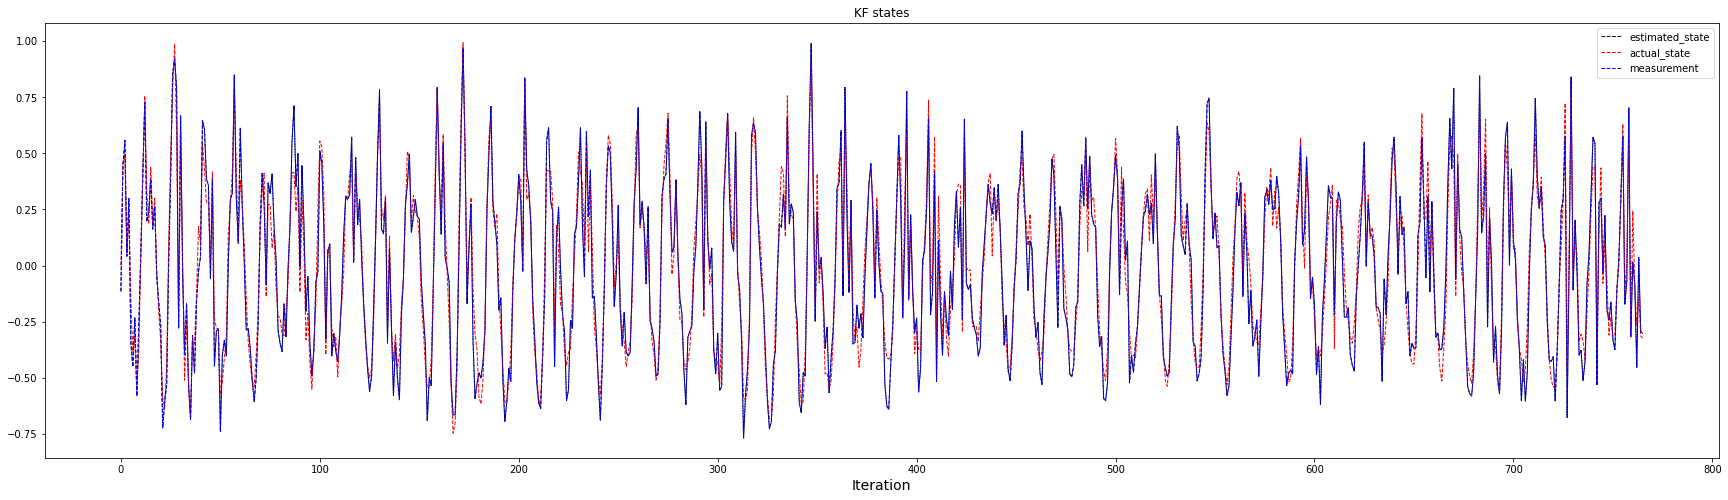

In [47]:
fig = plt.figure(figsize=(30,8))
ax = fig.add_subplot(111)

ax.plot([element[6] for element in estimated_states_results[1][100:500]], color="black", linewidth=1, linestyle="dashed", label="estimated_state")
ax.plot([element[6] for element in actual_states_results[1][1:-1]], color="red", linewidth=1, linestyle="dashed", label="actual_state")
ax.plot([element[6] for element in measurements_results[1][1:-1]], color="blue", linewidth=1, linestyle="dashed", label="measurement")

ax.set_title("KF states")
ax.set_xlabel("Iteration", fontsize=14)
ax.legend(loc='upper right')

Average stddev for state 0 is 0.0802302108692834
Average stddev for state 1 is 0.01305666461938923
Average stddev for state 2 is 0.01107077119525087
Average stddev for state 3 is 0.0009011313906460847
Average stddev for state 4 is 0.00023698396170725926
Average stddev for state 5 is 0.00044577065046749395
Average stddev for state 6 is 8.017754980742252
Average stddev for state 7 is 1.2604137854858983
Average stddev for state 8 is 0.9853310110200274
Average stddev for state 9 is 0.012333371098149101
Average stddev for state 10 is 0.015200679893270697
Average stddev for state 11 is 0.028277163175850512


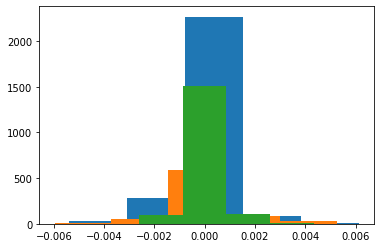

In [45]:
element_index = 3

for element_index_temp in range(12):
        print("Average stddev for state", element_index_temp, "is", np.mean([numpy.std(np.array([element[element_index_temp] for element in error_predicted_results[result_index][1:-1]])) for result_index in range(len(error_predicted_results))]))

for result_index in range(len(error_predicted_results)):
        plt.hist([element[element_index] for element in error_predicted_results[result_index][1:-1]], bins=5)

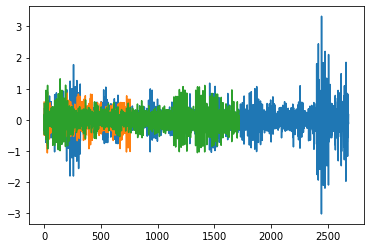

In [46]:
for result in error_results:
    plt.plot([element[6] for element in result[1:-1]])